# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Импорты

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn import utils

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

### Функции

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
def distribution_overview(dFrame, attribute, title, scale=0.028, bns=None):
    mean = round(dFrame[attribute].mean(), 2)
    median = dFrame[attribute].median()
    mode = dFrame[attribute].mode()[0]
    min = dFrame[attribute].min()
    max = dFrame[attribute].max()
    q25 = dFrame[attribute].quantile(0.25)
    q75 = dFrame[attribute].quantile(0.95)
    q01 = dFrame[attribute].quantile(0.005)
    q99 = dFrame[attribute].quantile(0.995)

    plt.figure(figsize = (12, 8))
    sns.distplot(dFrame.loc[dFrame[attribute].notnull(), attribute], bins=bns)

    y = np.linspace(0, scale, 100)
    plt.plot([mean]*100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([median]*100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([mode]*100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title(title)
    plt.legend()

    print(f'min: {min}, quantile 0,01: {q01}, quantile 0,25: {q25}, mean: {mean}, median: {median}, mode: {mode}, quantile 0,75: {q75}, quantile 0,99: {q99}, max: {max}')

    plt.show()

### Описание датасета

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Файло

In [4]:
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
TEST_DATASET_PATH = 'test.csv'

In [6]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [7]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [8]:
DF_TEST_RESULT_DATASET_PATH = 'df_test_res.csv'

### Загрузка данных

In [9]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов данных

### Тренировочный набор

In [11]:
train.shape

(10000, 20)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [13]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [14]:
train['Rooms'].dtype

dtype('float64')

In [15]:
train['Rooms'] = train['Rooms'].astype('int64')

In [16]:
train['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [17]:
train['HouseFloor'].dtype

dtype('float64')

In [18]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')

In [19]:
train['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [20]:
train['KitchenSquare'].dtype

dtype('float64')

In [21]:
train['KitchenSquare'] = train['KitchenSquare'].astype('int64')

In [22]:
train['KitchenSquare'].dtype

dtype('int64')

### Тестовый набор

In [23]:
test.shape

(5000, 19)

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [25]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

Количество комнат должно быть целым числом.

In [26]:
test['Rooms'].dtype

dtype('float64')

In [27]:
test['Rooms'] = test['Rooms'].astype('int64')

In [28]:
test['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [29]:
test['HouseFloor'].dtype

dtype('float64')

In [30]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [31]:
test['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [32]:
test['KitchenSquare'].dtype

dtype('float64')

In [33]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [34]:
test['KitchenSquare'].dtype

dtype('int64')

### Объединение наборов для предварительной обработки

Объединим оба набора для вычищения данных.

In [35]:
df = pd.concat((train, test), sort=False).reset_index(drop=True)

In [36]:
df.shape

(15000, 20)

### Статистика

In [37]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор количественных переменных

In [38]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Обзор номинативных переменных

In [39]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [40]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [41]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [42]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка пропусков

In [43]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [44]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

1    1285
2    1271
3     577
4      15
0       3
5       2
6       1
Name: Rooms, dtype: int64

In [45]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

1977    2757
2016     102
2015      89
2017      87
2014      62
2018      33
2013      11
2019      10
2020       2
2012       1
Name: HouseYear, dtype: int64

In [46]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [47]:
df.loc[df['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0,49.483501,NaN,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
12071,10793,23,6,110.750226,NaN,0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN


Заполним оставшееся пустое значение в зависимости от среза по площади.

In [48]:
df.loc[df['Id'] == 770, 'LifeSquare'] = df.loc[df['Square'].between(49.0, 50.0), 'Rooms'].median()

In [49]:
df.loc[df['Id'] == 10793, 'LifeSquare'] = df.loc[df['Square'].between(100.0, 120.0), 'Rooms'].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [50]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [51]:
values = sorted(values)

In [52]:
length = len(values)

In [53]:
length

79

In [54]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [55]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [56]:
b = df.loc[df['Healthcare_1'].isnull()]

In [57]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [58]:
df['Ecology_2'].mode()[0]

'B'

In [59]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [60]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

**Ecology_3**

In [61]:
df['Ecology_3'].mode()[0]

'B'

In [62]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [63]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

**Shops_2**

In [64]:
df['Shops_2'].mode()[0]

'B'

In [65]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [66]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка выбросов

In [67]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,38.524649,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1258.720600,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,63.498418,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1137.424206,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,25.611946,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,33.768078,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,49.113026,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1894.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Почти все признаки имеют выбросы.

In [68]:
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,B,B,33,7976,5,2643.0,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3,80.384479,46.683720,12,5,17,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2,62.254114,37.160377,7,3,5,1960,0.460556,B,B,20,4386,14,1340.0,1,5,B,296021.204377
7,11993,74,2,80.312926,53.983730,0,14,0,1977,0.075779,B,B,6,1437,3,1970.0,0,2,B,221244.156664
8,5172,1,2,64.511437,53.983730,1,9,17,1977,0.007122,B,B,1,264,0,165.0,0,1,B,229102.795999
9,8649,23,1,46.461409,18.915552,8,13,17,2014,0.075779,B,B,6,1437,3,1084.0,0,2,B,95380.220993


In [69]:
df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14990,15706,94,2,47.776485,27.920873,6,8,9,1970,0.282798,B,B,33,8667,2,3300.0,0,6,B,NaN
14991,2105,64,2,45.493240,32.022565,6,4,9,1974,0.135650,B,B,46,7960,6,350.0,3,11,B,NaN
14992,7220,96,3,80.182493,48.627326,10,10,17,2003,0.041116,B,B,53,14892,4,125.0,1,4,B,NaN
14993,14562,113,2,46.627882,27.058739,5,6,5,1969,0.307467,B,A,30,5048,9,325.0,2,5,B,NaN
14994,6836,39,2,45.131282,30.780551,6,2,5,1965,0.428826,B,B,25,5011,8,730.0,0,2,B,NaN
14995,8180,11,3,67.133911,50.809797,6,5,9,1973,0.000170,B,B,36,5992,0,370.0,1,1,B,NaN
14996,4695,1,1,40.198472,21.807061,10,12,17,2017,0.007122,B,B,1,264,0,990.0,0,1,B,NaN
14997,5783,12,3,77.842178,48.282625,9,23,22,1989,0.090799,B,B,74,19083,2,730.0,5,15,B,NaN
14998,4780,62,2,81.305222,53.983730,0,4,0,1977,0.072158,B,B,2,629,1,1970.0,0,0,A,NaN
14999,12504,30,2,60.555693,53.983730,1,10,17,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN


**Районы (DistrictId)**

In [70]:
df.sort_values(by="DistrictId", inplace=True)

In [71]:
DistrictId_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'DistrictId_Price':list(df.loc[df['Price'].notnull(), 'DistrictId'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 0.0, quantile 0,01: 3.1017584349748543e-06, quantile 0,25: 7.809895068987761e-05, mean: 0.0, median: 0.0001988650931393187, mode: 0.0, quantile 0,75: 0.0006745874999237103, quantile 0,99: 0.0012743769666656286, max: 0.0027145908018226333


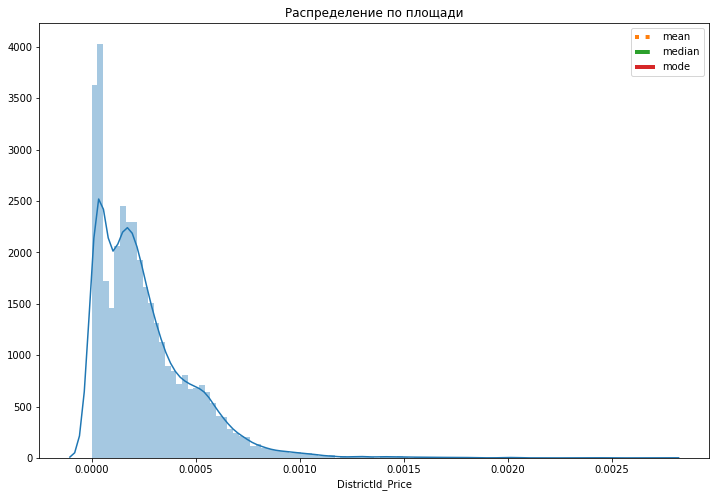

In [72]:
distribution_overview(DistrictId_Price, 'DistrictId_Price', 'Распределение по площади', 0.0062, 100)

In [73]:
id_list = list(DistrictId_Price.loc[DistrictId_Price['DistrictId_Price'] > 0.001, 'Id'])

In [74]:
df.loc[df['Id'].isin(id_list), 'DistrictId'].value_counts()

187    7
99     5
164    4
119    3
165    3
      ..
177    1
103    1
173    1
171    1
189    1
Name: DistrictId, Length: 65, dtype: int64

In [75]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4739,12676,81,3,13.784865,15.988889,7,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
3544,579,84,2,45.301564,28.938437,5,3,5,1961,0.006076,B,B,30,5285,0,645.0,6,6,B,63136.859879
1034,13715,91,2,41.881139,25.494645,7,6,9,1970,0.000995,B,B,42,7651,1,4129.0,1,5,B,62483.977998
6024,6128,92,2,56.084601,34.380524,8,6,14,1999,0.460556,B,B,20,4386,14,229.0,1,5,B,90471.540918
8124,13204,93,1,68.218458,64.800783,1,3,9,2013,0.012522,B,B,2,507,0,35.0,0,0,B,86540.216330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4484,5084,192,2,42.907811,26.390248,6,2,5,1963,0.319809,B,B,25,4756,16,2857.0,5,8,B,183319.371022
2384,11949,193,1,35.784271,20.656814,5,1,5,1969,0.319809,B,B,25,4756,16,2857.0,5,8,B,130500.697853
9520,4050,193,2,46.034264,33.918107,5,4,5,1966,0.319809,B,B,25,4756,16,2857.0,5,8,B,181025.397125
3714,12865,201,2,44.401451,26.027903,5,3,9,1967,0.081943,B,B,20,2738,20,1020.0,1,4,B,174216.778670


In [76]:
df.loc[df['Id'].isin(id_list), 'DistrictId'] = df['DistrictId'].median()

In [77]:
df.loc[df['DistrictId'].notnull(), 'DistrictId']

8969       0.0
4374       0.0
2853       0.0
9840       0.0
5577       0.0
         ...  
13194    209.0
7650      37.0
11043    210.0
12666    211.0
10051    212.0
Name: DistrictId, Length: 15000, dtype: float64

In [78]:
df.loc[df['DistrictId'].notnull(), 'DistrictId'].value_counts()

27.0     1242
1.0       996
23.0      829
6.0       768
9.0       426
         ... 
174.0       1
211.0       1
207.0       1
204.0       1
198.0       1
Name: DistrictId, Length: 212, dtype: int64

min: 0.0, quantile 0,01: 1.0, quantile 0,25: 20.0, mean: 49.94, median: 37.0, mode: 27.0, quantile 0,75: 138.0, quantile 0,99: 188.0, max: 212.0


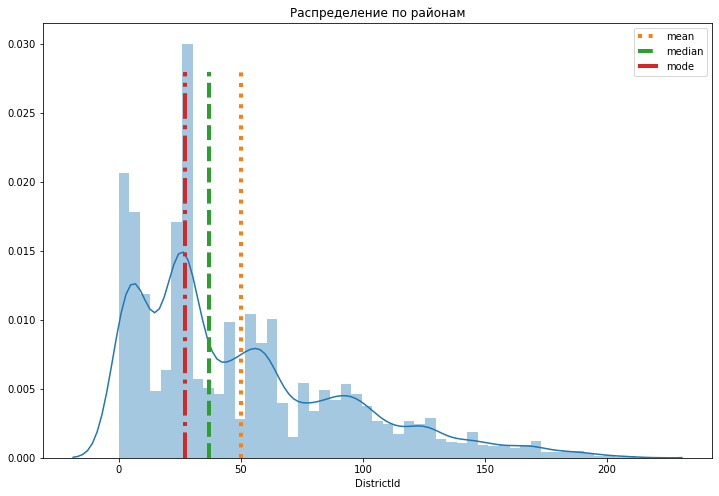

In [79]:
distribution_overview(df, 'DistrictId', 'Распределение по районам', 0.028)

Распределение по районам без особых выбросов.

**Распределение по комнатам (Rooms)**

In [80]:
df['Rooms'].unique()

array([ 2,  3,  1,  4, 19,  0,  5, 10,  6, 17], dtype=int64)

In [81]:
df.sort_values(by="Rooms", inplace=True)

In [82]:
df.loc[df['Rooms'].notnull(), 'Rooms']

3911      0
1397      0
4366      0
6149      0
12524     0
         ..
13217     6
377      10
8849     10
13398    17
1454     19
Name: Rooms, Length: 15000, dtype: int64

In [83]:
df.loc[df['Rooms'].notnull(), 'Rooms'].value_counts()

2     5910
1     5474
3     3334
4      240
5       25
0       10
6        3
10       2
19       1
17       1
Name: Rooms, dtype: int64

Есть выбросы для квартир к количеством комнат: 0, 6, 10, 19, 17

In [84]:
df.loc[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28.0,0,49.483501,2.000000,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
1397,12638,27.0,0,138.427694,136.215499,0,4,3,2016,0.075424,B,B,11,3097,0,645.0,0,0,B,268394.744389
4366,456,6.0,0,81.491446,63.973134,0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
6149,3159,88.0,0,38.697117,19.345131,9,9,16,1982,0.127376,B,B,43,8429,3,990.0,3,9,B,158998.110646
12524,10729,27.0,0,76.345154,42.820796,12,14,0,1977,0.017647,B,B,2,469,0,2729.0,0,0,B,NaN
8834,9443,27.0,0,87.762616,85.125471,0,5,15,1977,0.211401,B,B,9,1892,0,1970.0,0,1,B,219281.918007
4853,3224,27.0,0,2.377248,0.873147,0,1,0,1977,0.017647,B,B,2,469,0,35.0,0,0,B,126596.941798
2269,7317,27.0,0,41.790881,63.973134,0,13,0,1977,0.211401,B,B,9,1892,0,2300.0,0,1,B,98129.976788
1981,7917,27.0,0,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1308.0,0,1,B,302211.260887
12406,3343,58.0,0,116.824201,113.692424,0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,NaN


In [85]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] < 45.0), 'Rooms'] = 1

In [86]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [87]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(65.0, 85.0), 'Rooms'] = 3

In [88]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(85.0, 105.0), 'Rooms'] = 4

In [89]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] > 106), 'Rooms'] = 5

In [90]:
df.loc[df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2170,14003,99.0,6,59.414334,38.702244,6,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
12071,10793,23.0,6,110.750226,3.000000,0,2,2,2015,0.014073,B,B,2,475,0,4129.0,0,0,B,NaN
13217,4058,27.0,6,223.453689,104.113552,16,2,2,2017,0.041116,B,B,53,14892,4,2078.0,1,4,B,NaN


In [91]:
df.loc[(df['Rooms'] == 6) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [92]:
df.loc[(df['Rooms'] == 6) & (df['Square'] > 106), 'Rooms'] = 5

In [93]:
df.loc[df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57.0,10,59.056975,36.223072,10,22,22,2002,0.090799,B,B,74,19083,2,1145.0,5,15,B,317265.323792
8849,14865,9.0,10,60.871266,38.420681,10,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [94]:
df.loc[df['Rooms'] == 10, 'Rooms'] = 2

In [95]:
df.loc[df['Rooms'] == 19]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1.0,19,42.006046,21.779288,7,17,17,2014,0.007122,B,B,1,264,0,1046.0,0,1,B,78364.616704


In [96]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

In [97]:
df.loc[df['Rooms'] == 17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
13398,1435,111.0,17,52.866107,32.528342,8,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B,NaN


In [98]:
df.loc[df['Rooms'] == 17, 'Rooms'] = 2

In [99]:
df['Rooms'].unique()

array([2, 5, 3, 1, 4], dtype=int64)

min: 1, quantile 0,01: 1.0, quantile 0,25: 1.0, mean: 1.9, median: 2.0, mode: 2, quantile 0,75: 3.0, quantile 0,99: 4.0, max: 5


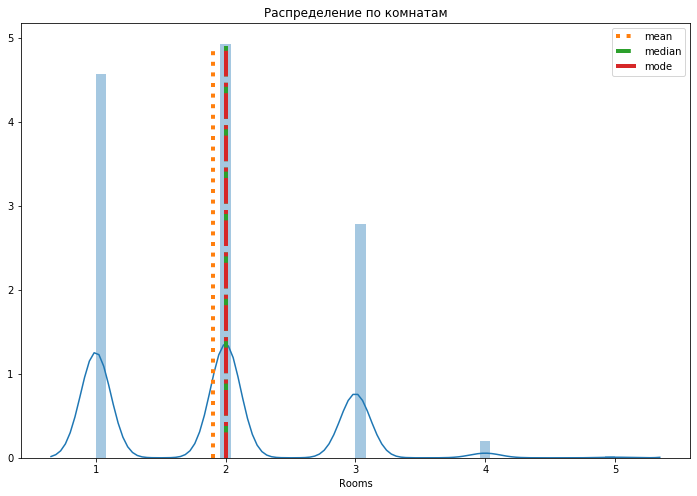

In [100]:
distribution_overview(df, 'Rooms', 'Распределение по комнатам', 4.9)

**Общая площадь квартиры (Square)**

In [101]:
df.sort_values(by="Square", inplace=True)

In [102]:
Square_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'Square_Price':list(df.loc[df['Price'].notnull(), 'Square'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 4.339081178854126e-06, quantile 0,01: 0.00012288337125399384, quantile 0,25: 0.0002131116523673229, mean: 0.0, median: 0.0002557510524445752, mode: 4.339081178854126e-06, quantile 0,75: 0.0005004050902978822, quantile 0,99: 0.0008064387505898329, max: 0.004800919055939031


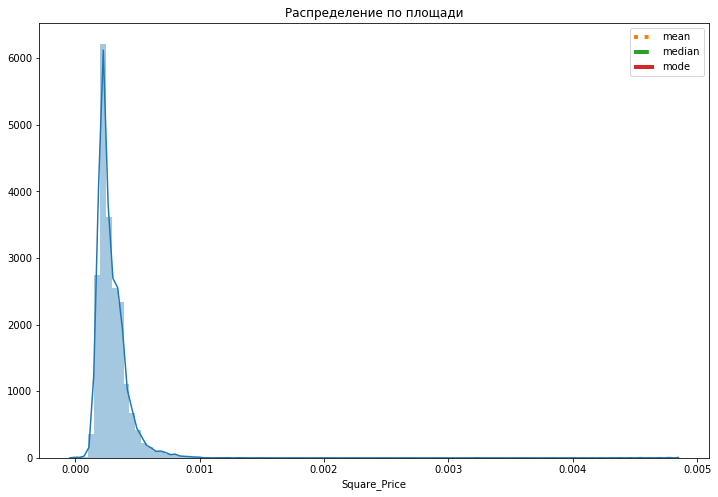

In [103]:
distribution_overview(Square_Price, 'Square_Price', 'Распределение по площади', 0.0062, 100)

In [104]:
id_list = list(Square_Price.loc[Square_Price['Square_Price'] > 0.0008, 'Id'])

In [105]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9732,13237,37.0,2,51.726692,30.547287,8,2,14,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
9705,11560,11.0,2,52.685729,34.636558,5,10,9,1973,0.000170,B,B,36,5992,0,1937.0,1,1,B,65343.643530
1622,11854,9.0,2,55.126426,29.914386,8,4,14,2004,0.130123,B,B,8,1986,0,1994.0,0,0,B,62126.665619
5813,8935,47.0,2,55.369224,30.587406,9,17,17,2010,0.197368,B,B,8,2423,1,32.0,0,1,B,66722.596920
522,671,23.0,2,55.869625,54.177713,10,3,17,2015,0.005767,B,B,1,388,0,1322.0,0,0,B,63900.205590
3605,7243,9.0,2,58.089253,52.460857,8,5,22,1981,0.136244,B,B,11,2370,0,240.0,0,1,B,59877.592523
3128,8823,7.0,2,59.466919,33.746589,9,18,16,2016,0.130618,B,B,39,10418,9,900.0,1,9,B,71291.546163
1884,7439,27.0,2,61.342410,33.767600,12,3,17,2014,0.072158,B,B,2,629,1,1308.0,0,0,A,67343.133878
2410,16148,19.0,2,61.464284,30.289514,13,9,15,2009,0.309479,B,B,35,7715,4,990.0,0,6,B,72430.588440
2413,9000,41.0,2,61.511547,32.941861,12,13,14,2010,0.175055,B,B,36,10055,3,200.0,1,0,B,75269.221823


In [106]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Жилая площадь (LifeSquare)**

In [107]:
df.sort_values(by="LifeSquare", inplace=True)

In [108]:
LifeSquare_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'LifeSquare_Price':list(df.loc[df['Price'].notnull(), 'LifeSquare'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 1.9028234778410429e-06, quantile 0,01: 1.0645955148672263e-05, quantile 0,25: 0.00012691026572289756, mean: 0.0, median: 0.00016199246386169652, mode: 1.9028234778410429e-06, quantile 0,75: 0.0004080407138031999, quantile 0,99: 0.000628741753558701, max: 0.03441607670151886


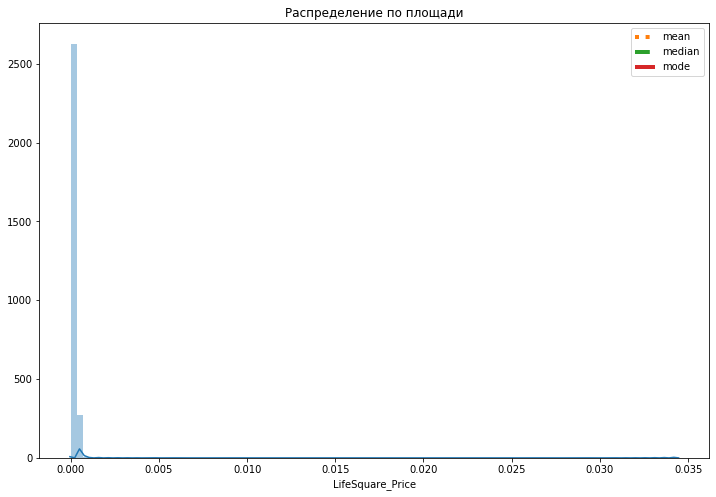

In [109]:
distribution_overview(LifeSquare_Price, 'LifeSquare_Price', 'Распределение по площади', 0.0062, 100)

In [110]:
id_list = list(LifeSquare_Price.loc[LifeSquare_Price['LifeSquare_Price'] > 0.0005, 'Id'])

In [111]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9732,13237,37.0,2,54.000000,30.547287,8,2,14,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
6856,2648,23.0,1,34.670830,31.425557,0,4,0,1977,0.005767,B,B,1,388,0,4508.0,0,0,B,60828.260686
9961,1579,23.0,1,27.331108,31.425557,1,10,12,1977,0.034656,B,B,0,168,0,1937.0,0,0,B,60825.032060
7850,8800,23.0,1,29.706031,31.425557,0,5,12,1977,0.034656,B,B,0,168,0,2729.0,0,0,B,60502.583500
8957,9042,23.0,1,32.233290,31.425557,0,3,4,1977,0.034656,B,B,0,168,0,1130.0,0,0,B,62225.023069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,14990,23.0,2,48.449873,263.542020,5,6,5,1972,0.075779,B,B,6,1437,3,520.0,0,2,B,141780.231857
4690,2307,37.0,1,35.000000,410.639749,10,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
8437,15886,85.0,3,78.059331,461.463614,10,12,16,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
6977,11602,30.0,2,59.000000,638.163193,10,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [112]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['LifeSquare'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'LifeSquare'] = round(result,0)

**Кухня (KitchenSquare)**

In [113]:
df.sort_values(by="KitchenSquare", inplace=True)

In [114]:
KitchenSquare_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'KitchenSquare_Price':list(df.loc[df['Price'].notnull(), 'KitchenSquare'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 0.0, quantile 0,01: 0.0, quantile 0,25: 7.396297733855102e-06, mean: 0.0, median: 2.740373925550216e-05, mode: 0.0, quantile 0,75: 7.495414539478623e-05, quantile 0,99: 0.00015008527374359845, max: 0.01866598713824867


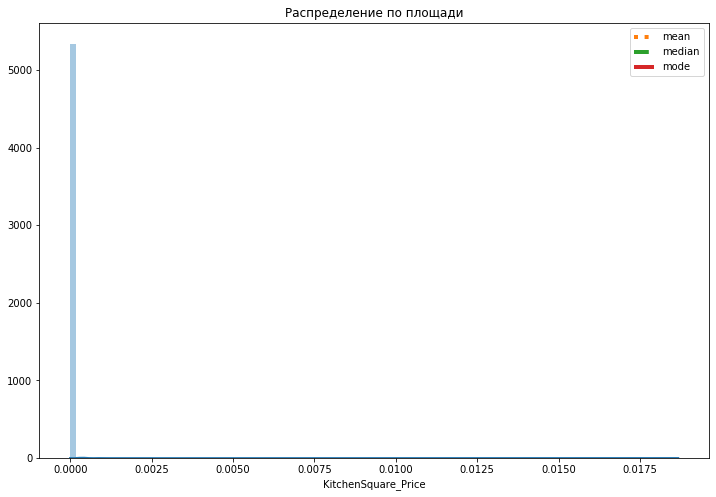

In [115]:
distribution_overview(KitchenSquare_Price, 'KitchenSquare_Price', 'Распределение по площади', 0.0062, 100)

In [116]:
id_list = list(KitchenSquare_Price.loc[KitchenSquare_Price['KitchenSquare_Price'] > 0.0001, 'Id'])

In [117]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['KitchenSquare'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'KitchenSquare'] = round(result,0)

**Этаж (Floor)**

In [118]:
df.sort_values(by="Floor", inplace=True)

In [119]:
Floor_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'Floor_Price':list(df.loc[df['Price'].notnull(), 'Floor'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 1.891930987310709e-06, quantile 0,01: 4.298236967642688e-06, quantile 0,25: 2.119189464749327e-05, mean: 0.0, median: 3.691233614386926e-05, mode: 1.891930987310709e-06, quantile 0,75: 0.0001114455265986329, quantile 0,99: 0.00018368046617406623, max: 0.0003282696178953763


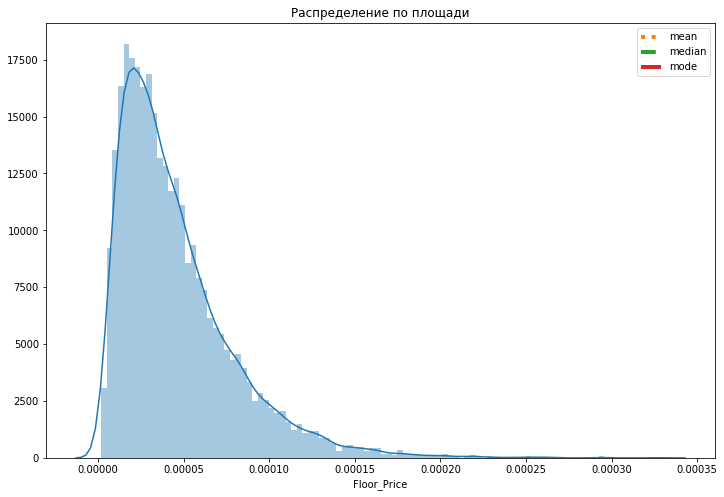

In [120]:
distribution_overview(Floor_Price, 'Floor_Price', 'Распределение по площади', 0.0062, 100)

In [121]:
id_list = list(Floor_Price.loc[Floor_Price['Floor_Price'] > 0.00018, 'Id'])

In [122]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Floor'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Floor'] = round(result,0)

**Этажность дома (HouseFloor)**

In [123]:
df.sort_values(by="HouseFloor", inplace=True)

In [124]:
HouseFloor_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'HouseFloor_Price':list(df.loc[df['Price'].notnull(), 'HouseFloor'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 0.0, quantile 0,01: 0.0, quantile 0,25: 3.518593363350446e-05, mean: 0.0, median: 5.873712823915239e-05, mode: 0.0, quantile 0,75: 0.00015799609870059268, quantile 0,99: 0.0002446585245120407, max: 0.0005645400236757653


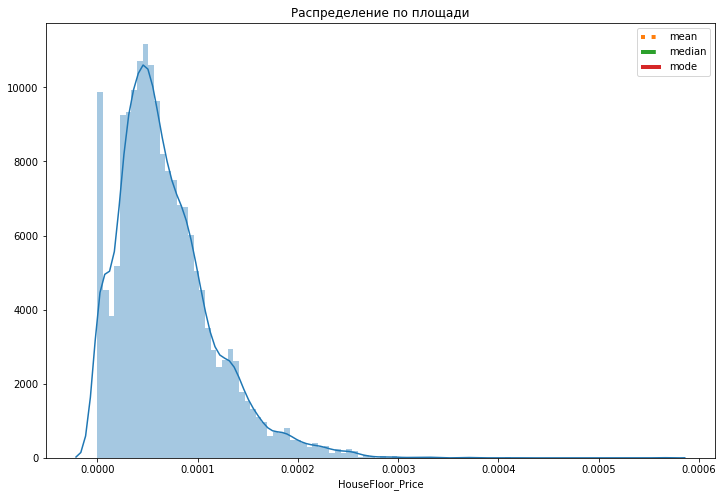

In [125]:
distribution_overview(HouseFloor_Price, 'HouseFloor_Price', 'Распределение по площади', 0.0062, 100)

In [126]:
id_list = list(HouseFloor_Price.loc[HouseFloor_Price['HouseFloor_Price'] > 0.0002, 'Id'])

In [127]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    result = df['HouseFloor'][(df['Rooms'] == rooms) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseFloor'] = round(result,0)

**Год постройки (HouseYear)**

In [128]:
df.sort_values(by="HouseYear", inplace=True)

In [129]:
HouseYear_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'HouseYear_Price':list(df.loc[df['Price'].notnull(), 'HouseYear'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 0.003111401619914465, quantile 0,01: 0.00351247762534546, quantile 0,25: 0.007963066345095207, mean: 0.02, median: 0.010319398968117885, mode: 0.003111401619914465, quantile 0,75: 0.020109086156605182, quantile 0,99: 0.029399250076198084, max: 78.91866007365189


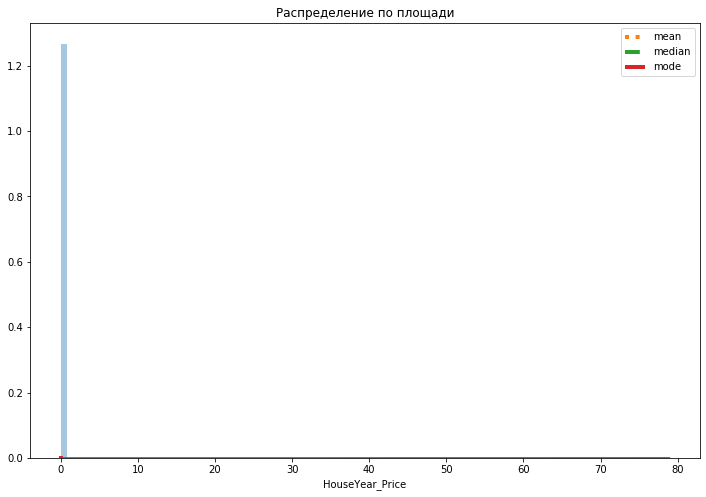

In [130]:
distribution_overview(HouseYear_Price, 'HouseYear_Price', 'Распределение по площади', 0.0062, 100)

In [131]:
id_list = list(HouseYear_Price.loc[HouseYear_Price['HouseYear_Price'] > 0.029, 'Id'])

In [132]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['HouseYear'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseYear'] = round(result,0)

### Отбор и построение новых признаков

In [133]:
df.sort_values(by="Id", inplace=True)

In [134]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [135]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [136]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [137]:
# df.drop(['Id'],axis=1,inplace=True)

In [138]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [139]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [140]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [141]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
7885,0,0.0,1,109.144492,84.613939,15.0,6.0,15.0,2011.0,0.319809,...,2857.0,5,8,289034.391871,0,1,0,1,0,1
14422,1,1.0,2,83.061098,83.830248,0.0,10.0,22.0,1977.0,0.007122,...,75.0,0,1,NaN,0,1,0,1,0,1
5549,2,2.0,1,34.472263,16.069376,5.0,5.0,18.0,1969.0,0.000000,...,125.0,2,5,174548.966339,0,1,0,1,0,1
10979,3,3.0,1,30.185483,14.810573,6.0,4.0,9.0,1970.0,0.265089,...,1937.0,3,2,NaN,0,1,0,1,0,1
14157,4,4.0,1,37.294669,17.165597,8.0,9.0,9.0,1970.0,0.327018,...,2500.0,1,0,NaN,0,1,0,1,0,1


Разобъем обратно набор данных df на 2 набора: тренировочный м икчирвый.

In [142]:
df_train = df.loc[df['Price'].notnull()]

In [143]:
df_test = df.loc[df['Price'].isnull()]

Сохраним эти наборы.

In [144]:
df_train.to_csv(DF_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [145]:
df_test.to_csv(DF_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

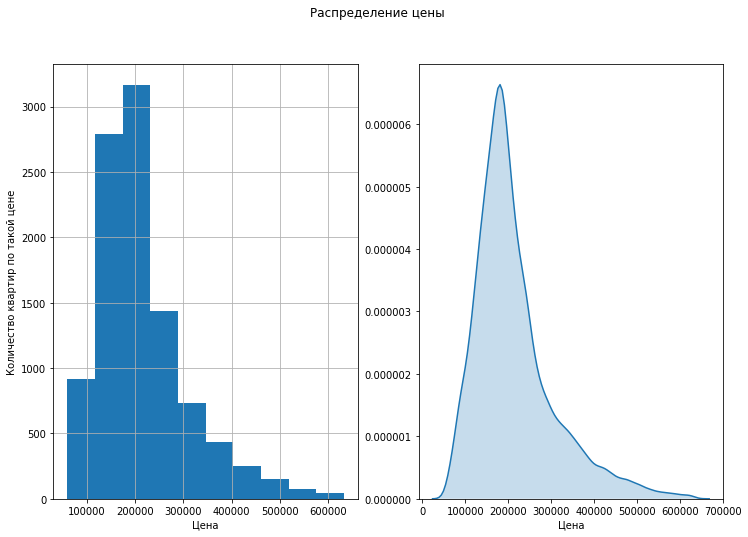

In [146]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [147]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

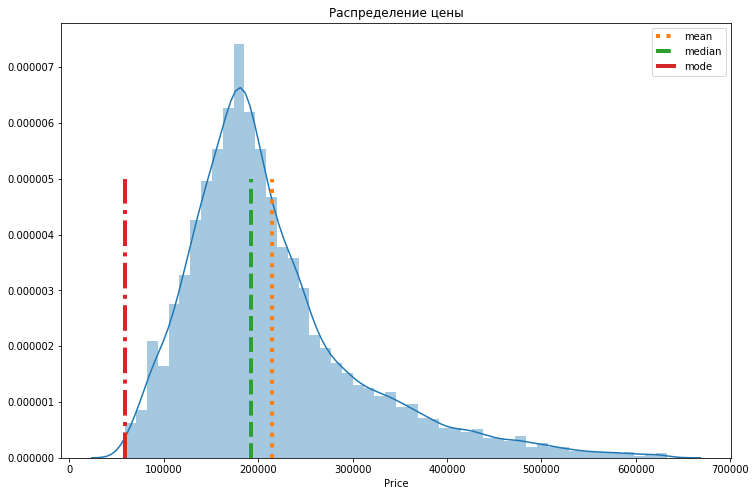

In [148]:
plt.figure(figsize = (12, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [149]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

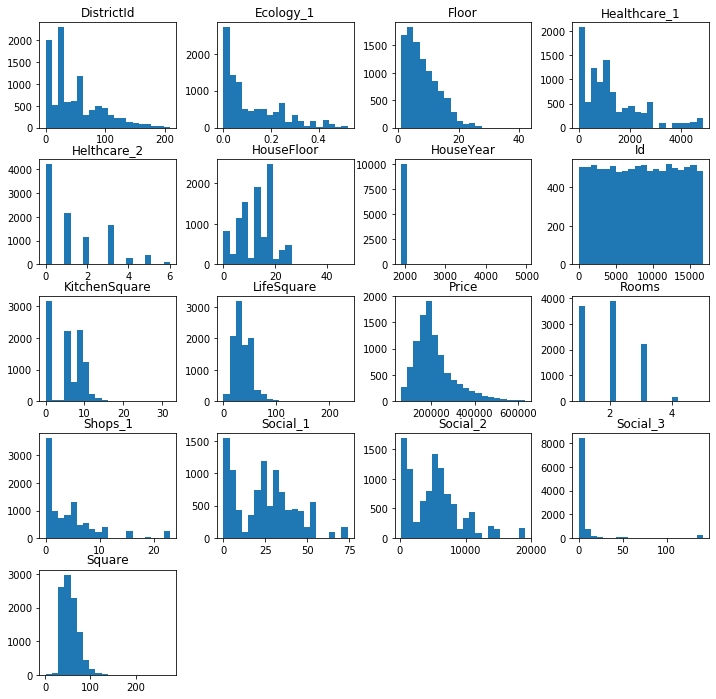

In [150]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

In [151]:
# sns.pairplot(df_num_features);

In [152]:
# grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

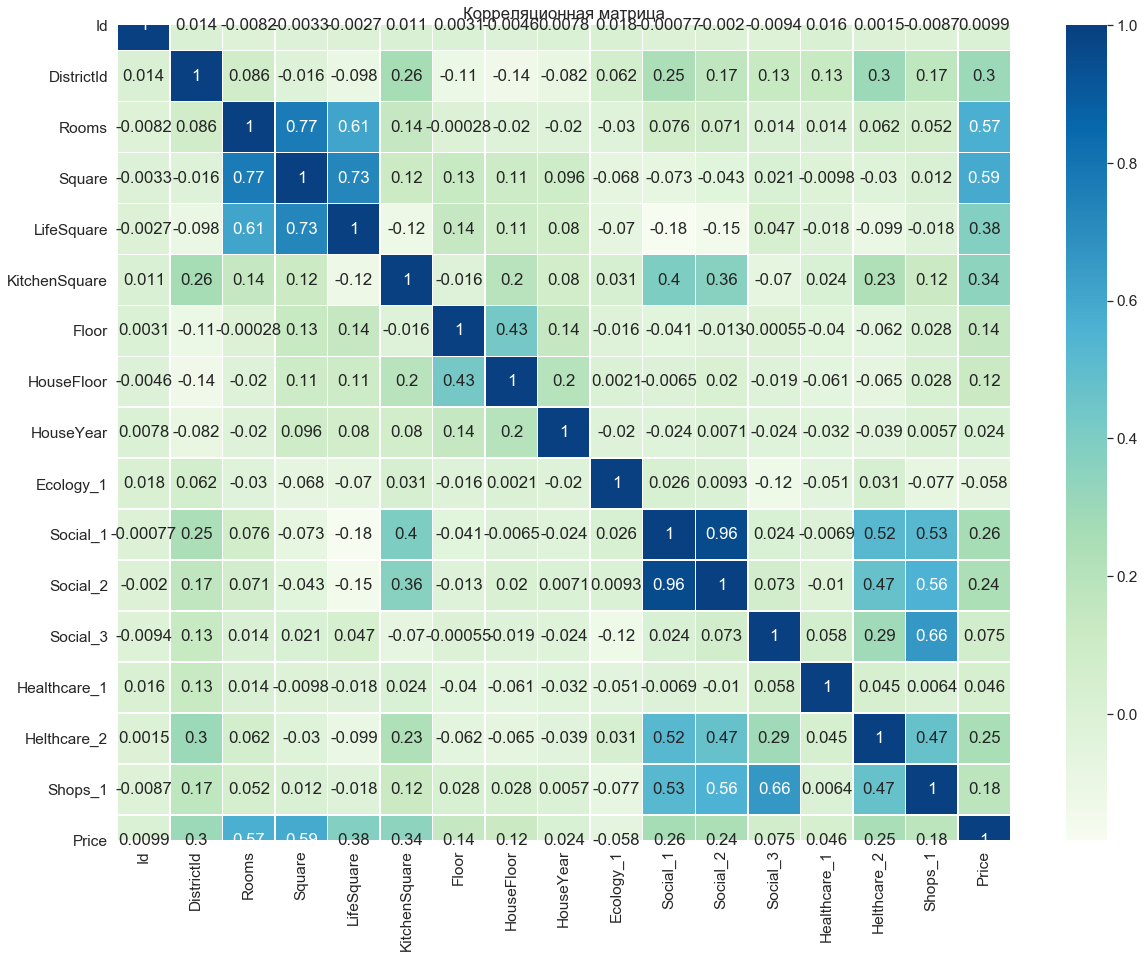

In [153]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

In [154]:
# grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [155]:
# grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [156]:
# grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [157]:
# grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [158]:
# grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

### Отбор признаков

In [159]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [160]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']
target_name = 'Price'

In [161]:
df_train = df_train[feature_names + [target_name]]
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
7885,0.0,1,109.144492,84.613939,15.0,6.0,15.0,2011.0,0.319809,25,...,16,5,8,0,1,0,1,0,1,289034.391871
5549,2.0,1,34.472263,16.069376,5.0,5.0,18.0,1969.0,0.000000,33,...,1,2,5,0,1,0,1,0,1,174548.966339
4808,5.0,3,57.607965,38.955672,5.0,3.0,9.0,1974.0,0.150818,16,...,4,4,5,0,1,0,1,0,1,258091.883679
4447,6.0,1,42.466813,40.010160,1.0,14.0,17.0,2014.0,0.243205,5,...,0,0,0,0,1,0,1,0,1,127196.762031
2684,6.0,3,75.888156,78.324716,1.0,11.0,17.0,2014.0,0.243205,5,...,0,0,0,0,1,0,1,0,1,218500.747041


### Стандартизация признаков

In [162]:
feature_names_for_stand = df_train[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1']

In [163]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_train[feature_names_for_stand])

In [164]:
stand_features

array([[-1.1615816 , -1.09369903,  2.8211861 , ...,  0.33405673,
         2.46430269,  0.78414926],
       [-1.11442877, -1.09369903, -1.1458809 , ..., -0.29538389,
         0.4556332 ,  0.15994256],
       [-1.04369953,  1.36709302,  0.08323573, ..., -0.16949577,
         1.79474619,  0.15994256],
       ...,
       [-0.07706658, -1.09369903, -1.22335664, ..., -0.16949577,
        -0.8834798 , -0.67233303],
       [ 1.05460126,  1.36709302,  1.13074554, ..., -0.25342119,
        -0.8834798 ,  0.36801146],
       [-0.6429005 , -1.09369903, -0.85449838, ..., -0.21145848,
         1.12518969, -0.04812634]])

In [165]:
df_train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [166]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
7885,-0.006337,0.136697,-0.808125,-0.910517,0.09463,-0.865792,-0.067811,-0.431236,-0.824372,-0.039186,...,-0.127533,0.455633,0.159943,0,1,0,1,0,1,289034.391871
5549,0.064392,-1.093699,-0.843785,-0.371236,-1.19602,0.486495,0.710013,-0.231456,2.119752,0.531208,...,-0.295384,0.455633,0.159943,0,1,0,1,0,1,174548.966339
4808,-0.949394,1.367093,0.260587,-0.021420,0.09463,0.486495,-0.534505,-0.259996,0.094651,-0.951817,...,-0.337347,-0.883480,-0.880402,0,1,0,1,0,1,258091.883679
4447,-0.124219,1.367093,0.238855,0.457718,0.09463,-0.672608,-0.534505,-0.402696,-0.695141,-0.039186,...,-0.337347,-0.213923,-0.672333,0,1,0,1,0,1,127196.762031
2684,-0.642901,0.136697,-0.698902,-0.494943,-0.16350,-0.865792,-1.156763,-0.573936,-0.990278,0.987523,...,-0.295384,-0.213923,0.159943,0,1,0,1,0,1,218500.747041


### Сохранение обучающего датасета

In [167]:
TRAIN_DATASET_PATH_ADD = 'df_train_add.csv'

In [168]:
TEST_DATASET_PATH_ADD = 'df_test_add.csv'

In [169]:
df_train.to_csv(TRAIN_DATASET_PATH_ADD, index=False, encoding='utf-8')

### Разбиение на train и test

In [170]:
X = df_train[feature_names]
y = df_train[target_name]

In [171]:
len(X) - X.count()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Ecology_2_A      0
Ecology_2_B      0
Ecology_3_A      0
Ecology_3_B      0
Shops_2_A        0
Shops_2_B        0
dtype: int64

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [173]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.01
MAE:	69480.559
MSE:	8676742055.226


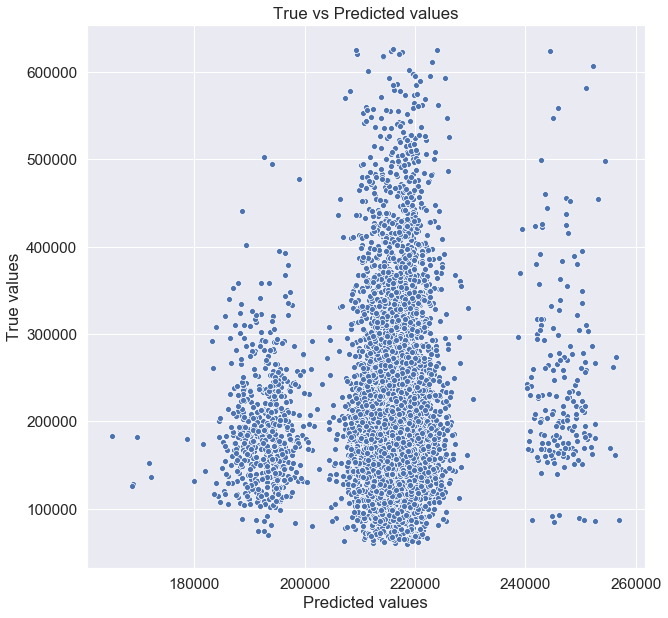

In [174]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [175]:
# sorted(y_train_preds)

R2:	0.002
MAE:	68102.953
MSE:	8307921109.369


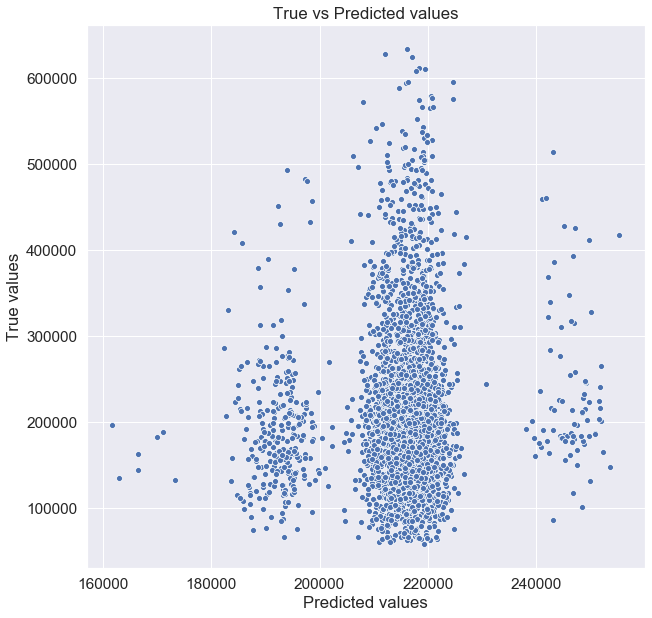

In [176]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [177]:
y_test_preds

array([219225.70757948, 211747.46825397, 211773.32870321, ...,
       219914.17212074, 217902.28433496, 217643.39837646])

In [178]:
lasso_model = Lasso(alpha=0.3)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

R2:	0.01
MAE:	69480.547
MSE:	8676742073.637


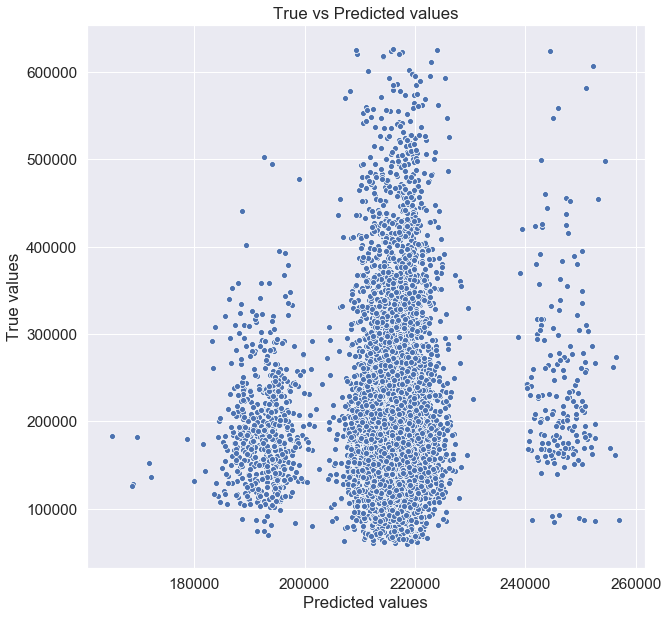

In [179]:
y_train_preds = lasso_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.002
MAE:	68102.816
MSE:	8307900968.929


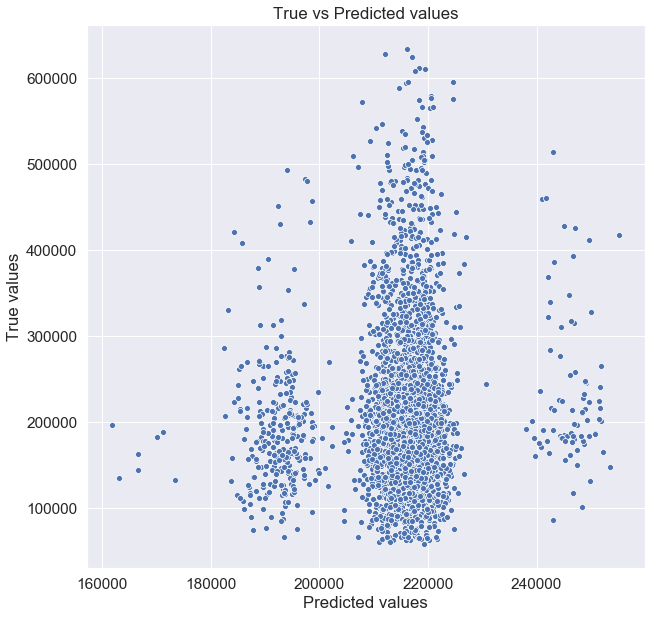

In [180]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [181]:
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

R2:	0.01
MAE:	69480.531
MSE:	8676742106.002


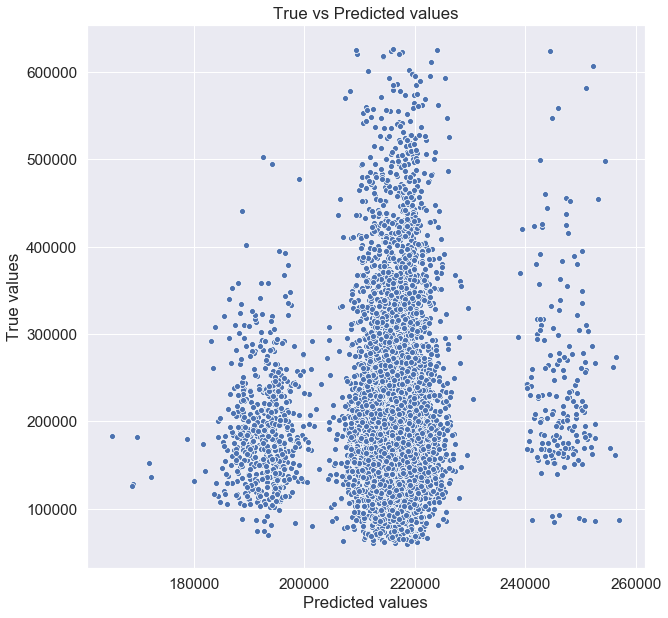

In [182]:
y_train_preds = ridge_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.002
MAE:	68102.816
MSE:	8307900968.929


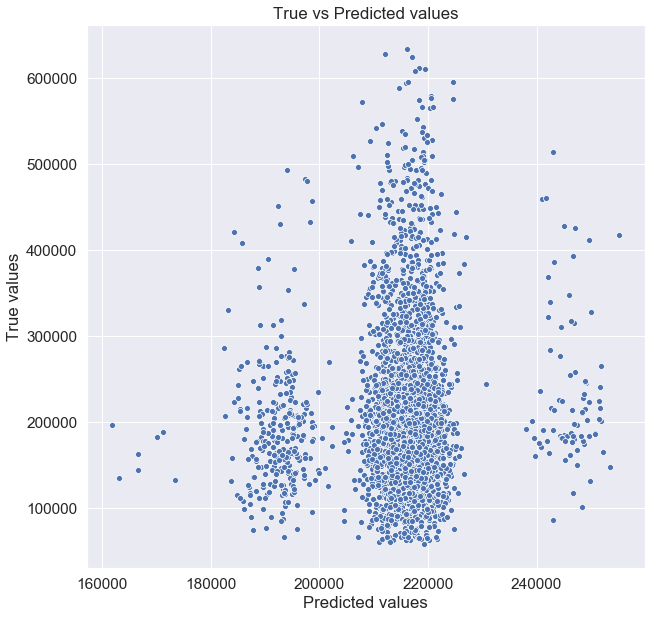

In [183]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [184]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.791
MAE:	30470.021
MSE:	1833686607.772


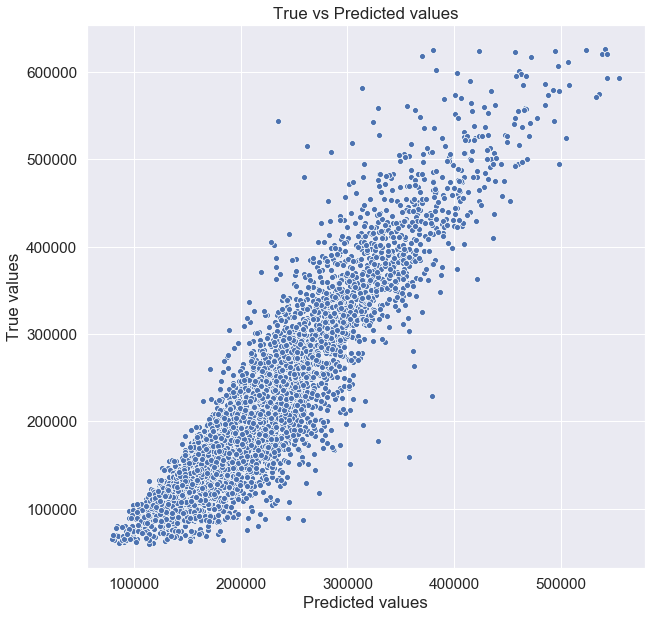

In [185]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.219
MAE:	76756.263
MSE:	10149824205.607


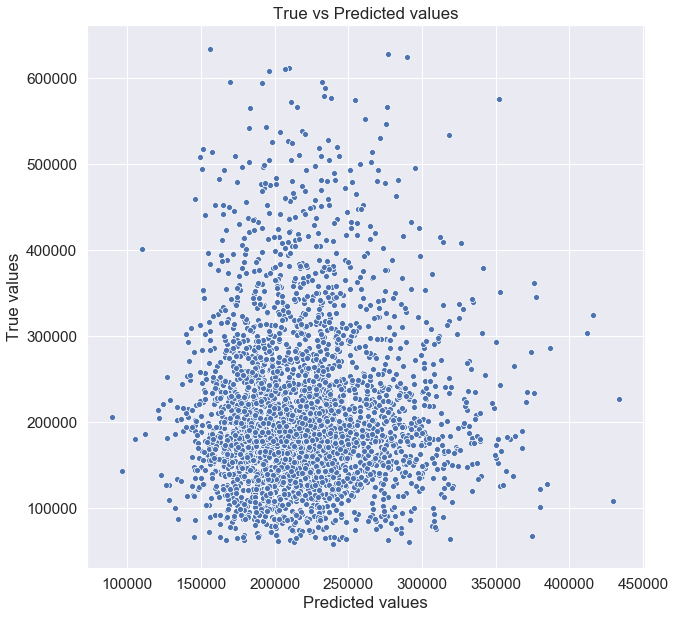

In [186]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [187]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.079
MAE:	67000.638
MSE:	8072258640.821


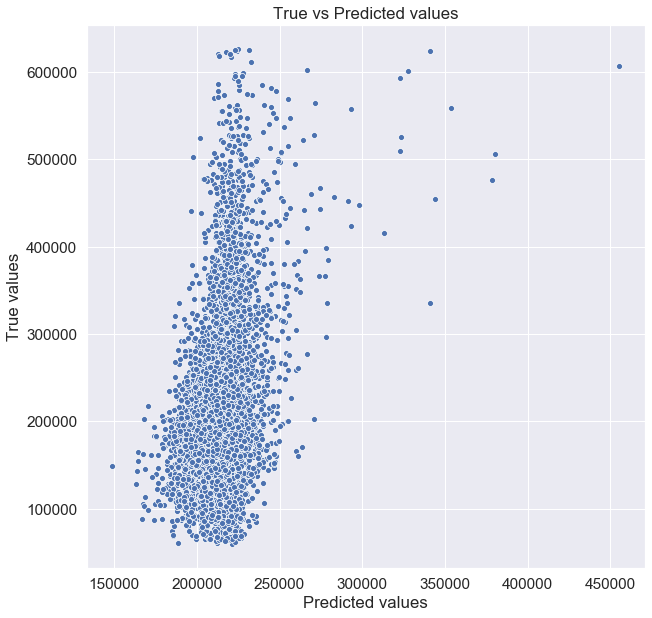

In [188]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.01
MAE:	68456.242
MSE:	8411040937.363


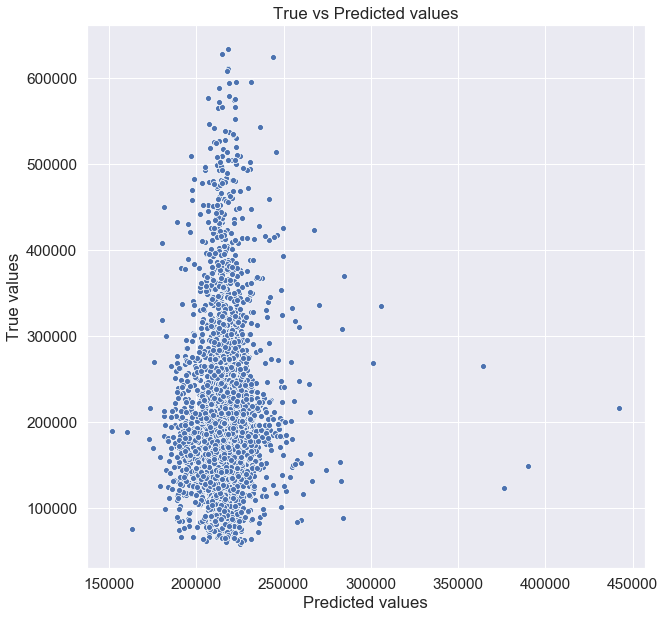

In [189]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [190]:
X_train.dtypes

DistrictId       float64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor            float64
HouseFloor       float64
HouseYear        float64
Ecology_1        float64
Social_1         float64
Social_2         float64
Social_3         float64
Helthcare_2      float64
Shops_1          float64
Ecology_2_A        uint8
Ecology_2_B        uint8
Ecology_3_A        uint8
Ecology_3_B        uint8
Shops_2_A          uint8
Shops_2_B          uint8
dtype: object

In [191]:
y_train.dtypes

dtype('float64')

In [192]:
# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_Y)

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_encoded)

In [193]:
log_r_model = LogisticRegression(solver="liblinear")
log_r_model.fit(X_train, y_train_encoded)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [194]:
? LogisticRegression

R2:	-5.109
MAE:	211921.781
MSE:	53565030681.985


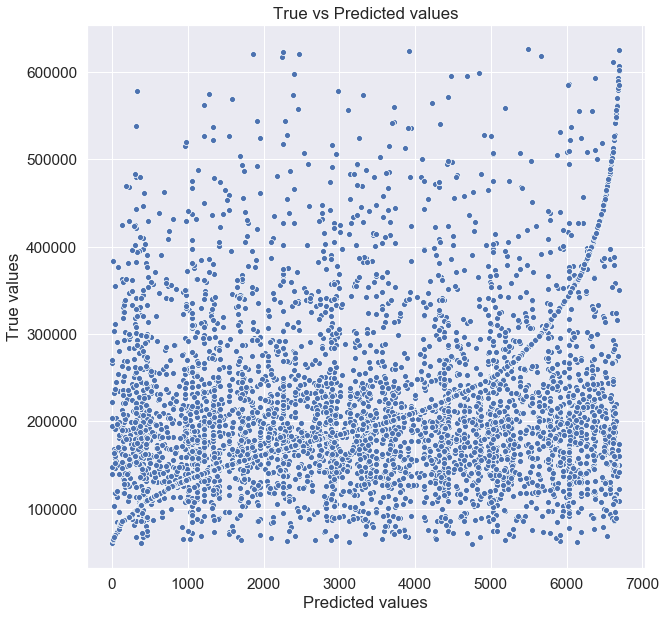

In [195]:
y_train_preds = log_r_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-5.227
MAE:	208576.272
MSE:	51839078412.109


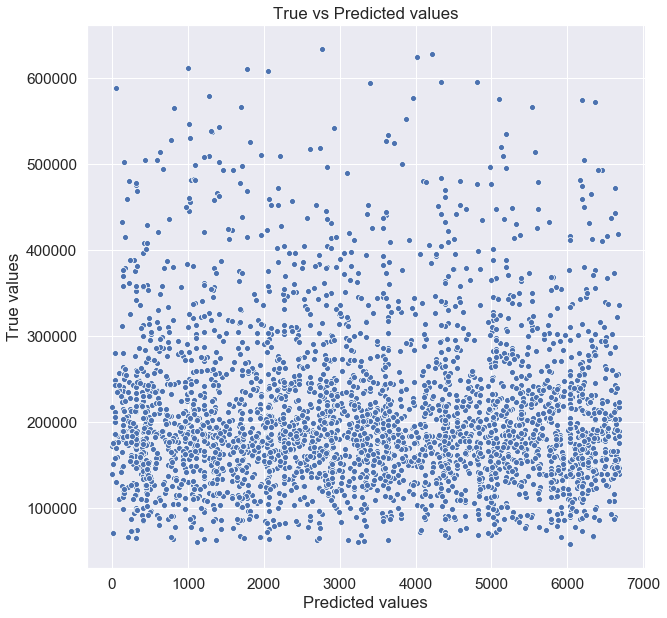

In [196]:
y_test_preds = log_r_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [197]:
X_test = df_test[feature_names]

In [198]:
y_test_preds = rf_model.predict(X_test)

In [199]:
y_test_preds

array([209846.6825651 , 327373.47983846, 330356.31294664, ...,
       333848.00780451, 351099.63393941, 327373.47983846])

In [200]:
df_res = pd.DataFrame({'Id':list(test['Id']),'Price':list(y_test_preds)})

In [201]:
df_res.to_csv(DF_TEST_RESULT_DATASET_PATH, index=False, encoding='utf-8')